## Tree Segmentation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

rand_seed = 42

datapath = "/home/derekdb/notebooks/uw-geohack-challenge/data"

# download training data

# import kaggle

# kaggle.api.authenticate()

# kaggle.api.dataset_download_files('bulentsiyah/semantic-drone-dataset', path=datapath, unzip=True)


path = Path(datapath)/'semantic_drone_dataset'

path_lbl_semantic = path/'label_images_semantic'
path_lbl_bin = path/'label_images_bin'
path_img = path/'original_images'


## Subset classes

In [2]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

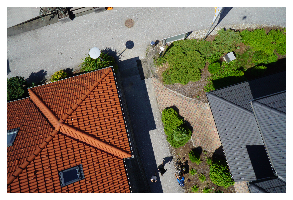

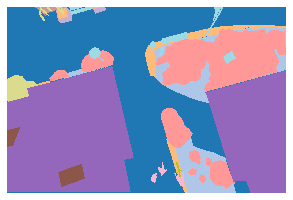

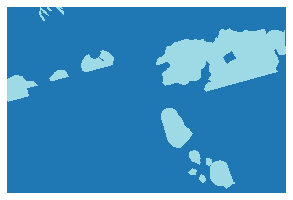

In [3]:
fnames = get_image_files(path_img)
fnames[:3]

lbl_names = get_image_files(path_lbl_semantic)
lbl_names[:3]

img_f = fnames[151]
img = open_image(img_f)
img.show(figsize=(5,5))

get_y_fn = lambda x: (path_lbl_semantic/x.stem).with_suffix('.png')
get_y_fn_bin = lambda x: (path_lbl_bin/x.stem).with_suffix('.png')

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

src_size = np.array(mask.shape[1:])
src_size,mask.data

# obtain validation list
# fns = [x.name for x in fnames]
# from random import sample
# random.seed(rand_seed)
# valid_list = sample(fns, len(fns)//5)
# print(valid_list)
# with open(path/'valid.txt', 'w') as handle:
#     handle.write('\n'.join(valid_list))



# In the masks, pixel_val=8 indicates trees, and all the other pixel levels are irrelevant. 
# Hence, we can simplify the problem to a binary segmentation problem and transform the images
# import cv2

# def create_new_labels(img_fn, tree_codes=[8,19]):
#     img_arr = cv2.imread(str(get_y_fn(img_fn)))
#     img_arr[img_arr==1] = 0
#     for c in tree_codes:
#         img_arr[img_arr==c] = 1 
#     img_arr[img_arr!=1] = 0
# #     print(str(get_y_fn_bin(img_fn)))
#     cv2.imwrite(str(get_y_fn_bin(img_fn)), img_arr)

# Path(path_lbl_bin).mkdir(parents=True, exist_ok=True)
# [create_new_labels(f) for f in fnames]
# create_new_labels(fnames[151])
# print(fnames[151])

# make sure labels are correctly converted
mask = open_mask(get_y_fn_bin(fnames[151]))
mask.show(figsize=(5,5), alpha=1)


codes = array(['Background', 'Tree'])

## Datasets

In [ ]:
size = src_size//8

In [ ]:
# learn.destroy()
gc.collect()
torch.cuda.empty_cache()
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
bs = 4

print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [7]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn_bin, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(2, figsize=(10,7), alpha=0.7)

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [4]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

def acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

void_code

metrics=acc
# metrics=accuracy

wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
lr_find(learn)


In [ ]:
learn.recorder.plot()

In [ ]:
lr=1e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9) #train for 3 cycles

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-2');

In [ ]:
learn.show_results(rows=3, figsize=(8,9), alpha=0.9)

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [5]:
# learn.destroy() 

size = src_size//4

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
# if free > 8200: bs=3
# else:           bs=1
bs = 1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 11429MB of GPU RAM free


In [8]:
data = (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [9]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [10]:
learn.load('stage-2');

In [ ]:
lr_find(learn)

In [ ]:
learn.recorder.plot()

In [ ]:
lr=1e-5

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [11]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-5, 1e-4)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

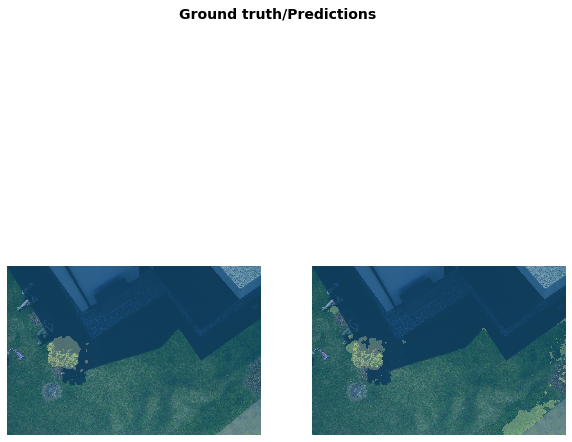

In [13]:
learn.show_results(rows=3, figsize=(10,10))

In [30]:
path = Path(datapath)/'eval_data/images'
fnames = get_image_files(path)
fnames[0]

PosixPath('/home/derekdb/notebooks/uw-geohack-challenge/data/eval_data/images/ortho_eval.tif')

/home/derekdb/notebooks/uw-geohack-challenge/data/eval_data/images/ortho_eval.tif


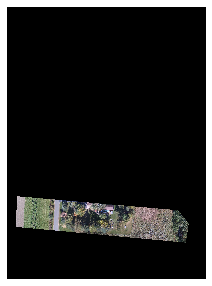

In [32]:
temp = open_image(fnames[0])
temp.show(figsize=(5,5))
print(fnames[0])


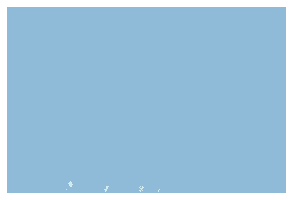

In [33]:
prediction = learn.predict(temp)
prediction[0].show(figsize=(5,5))

## fin